# **Imports**

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import shutil

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model, Model
from tensorflow.keras.layers import MaxPooling2D, Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import load_img
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import RandomRotation, RandomContrast, RandomZoom, RandomFlip, RandomTranslation
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications import VGG16

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, accuracy_score

import csv
import pandas as pd
from sklearn.metrics import mean_squared_error, recall_score, f1_score

2024-05-18 20:58:37.327928: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-18 20:58:37.328046: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-18 20:58:37.446607: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **Variables**

In [2]:
num_classes = 4
image_shape = (224, 224, 3) 
class_mappings = {'Glioma': 0, 'Meninigioma': 1, 'Notumor': 2, 'Pituitary': 3}
batch_size = 32
image_dim = (224, 224)
epochs = 80
SEED= 111

# **Splitting data into train and test** 

In [3]:
# Define input and output directories
input_dir = '/kaggle/input/brain-tumor-mri-images-224x224/dataset'
output_dir = '/kaggle/working/dataset'

# Create Train and Test directories
train_dir = os.path.join(output_dir, 'Train')
test_dir = os.path.join(output_dir, 'Test')
os.makedirs(train_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Move files to Train and Test directories
for tumor_type in os.listdir(input_dir):
    tumor_dir = os.path.join(input_dir, tumor_type)
    
    # Splitting data into train and test in 80-20 ratio
    files = os.listdir(tumor_dir)
    split_idx = int(0.8 * len(files))
    train_files = files[:split_idx]
    test_files = files[split_idx:]
    
    # Create directories for tumor types in Train and Test directories
    train_tumor_dir = os.path.join(train_dir, tumor_type)
    test_tumor_dir = os.path.join(test_dir, tumor_type)
    os.makedirs(train_tumor_dir, exist_ok=True)
    os.makedirs(test_tumor_dir, exist_ok=True)
    
    # Move files to Train and Test directories
    for file in train_files:
        src = os.path.join(tumor_dir, file)
        dest = os.path.join(train_tumor_dir, file)
        shutil.copy(src, dest)
        
    for file in test_files:
        src = os.path.join(tumor_dir, file)
        dest = os.path.join(test_tumor_dir, file)
        shutil.copy(src, dest)

print("Dataset reorganized successfully!")

Dataset reorganized successfully!


# **Data Processing Functions** 

In [4]:
def get_data_labels(directory, shuffle=True, random_state=0):
    from sklearn.utils import shuffle
    data_path = []
    data_index = []
    label_dict = {label: index for index, label in enumerate(sorted(os.listdir(directory)))}
    
    for label, index in label_dict.items():
        label_dir = os.path.join(directory, label)
        for image in os.listdir(label_dir):
            image_path = os.path.join(label_dir, image)
            data_path.append(image_path)
            data_index.append(index)
            
    if shuffle:
        data_path, data_index = shuffle(data_path, data_index, random_state=random_state)
            
    return data_path, data_index

def parse_function(filename, label, image_size, n_channels):
    image_string = tf.io.read_file(filename)
    image = tf.image.decode_jpeg(image_string, n_channels)
    image = tf.image.resize(image, image_size)
    return image, label

def get_dataset(paths, labels, image_size, n_channels=3, num_classes=4, batch_size=32):
    path_ds = tf.data.Dataset.from_tensor_slices((paths, labels))
    image_label_ds = path_ds.map(lambda path, label: parse_function(path, label, image_size, n_channels), 
                                 num_parallel_calls=tf.data.AUTOTUNE)
    return image_label_ds.batch(batch_size).prefetch(buffer_size=tf.data.AUTOTUNE)

In [5]:
# Getting data labels
USER_PATH = "/kaggle/working/dataset"
train_paths, train_index = get_data_labels(USER_PATH + '/Train', random_state=SEED)
test_paths, test_index = get_data_labels(USER_PATH + '/Test', random_state=SEED)

# Prepare datasets with 4 classes and grayscale
train_ds = get_dataset(train_paths, train_index, image_dim, n_channels=3, num_classes=4, batch_size=batch_size)
test_ds = get_dataset(test_paths, test_index, image_dim, n_channels=3, num_classes=4, batch_size=batch_size)

# Class mappings
inv_class_mappings = {v: k for k, v in class_mappings.items()}
class_names = list(class_mappings.keys())

# **Data Visualization**

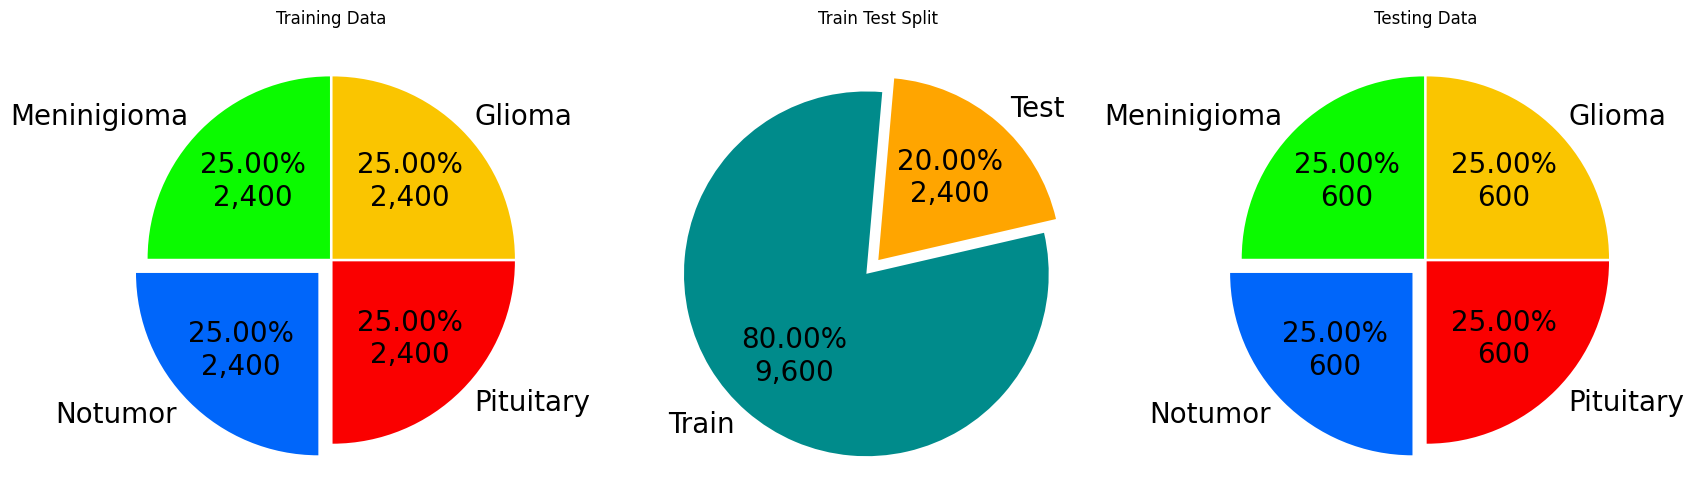

In [6]:
_, ax = plt.subplots(ncols=3, figsize=(20, 14))

# Plotting training data types
class_counts = [len([x for x in train_index if x == label]) for label in set(train_index)]
ax[0].set_title('Training Data')
ax[0].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500','#0BFA00', '#0066FA','#FA0000'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20}
)

# Plotting distribution of train test split
ax[1].set_title('Train Test Split')
ax[1].pie(
    [len(train_index), len(test_index)],
    labels=['Train','Test'],
    colors=['darkcyan', 'orange'], 
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum([len(train_index), len(test_index)]) / 100),
    explode=(0.1, 0),
    startangle=85,
    textprops={'fontsize': 20}
)

# Plotting testing data types
class_counts = [len([x for x in test_index if x == label]) for label in set(test_index)]
ax[2].set_title('Testing Data')
ax[2].pie(
    class_counts,
    labels=[label for label in class_names],
    colors=['#FAC500', '#0BFA00', '#0066FA', '#FA0000'],
    autopct=lambda p: '{:.2f}%\n{:,.0f}'.format(p, p * sum(class_counts) / 100),
    explode=(0.01, 0.01, 0.1, 0.01),
    textprops={'fontsize': 20} 
)

plt.show()

# **Viewing Image Data**

In [7]:
# Function to display a list of images based on the given index
def show_images(paths, label_paths, class_mappings, index_list=range(10), im_size=224, figsize=(12, 8)):
    
    num_images = len(index_list)
    num_rows = (num_images + 3) // 4
    index_to_class = {v: k for k, v in class_mappings.items()}
    _, ax = plt.subplots(nrows=num_rows, ncols=4, figsize=figsize)
    ax = ax.flatten()
    
    for i, index in enumerate(index_list):
        if i >= num_images:
            break
        image = load_img(paths[index], target_size=(im_size, im_size))
        ax[i].imshow(image, cmap='Greys_r')
        class_name = index_to_class[label_paths[index]]
        ax[i].set_title(f'{index}: {class_name}')
        ax[i].axis('off')
        
    plt.tight_layout()
    plt.show()

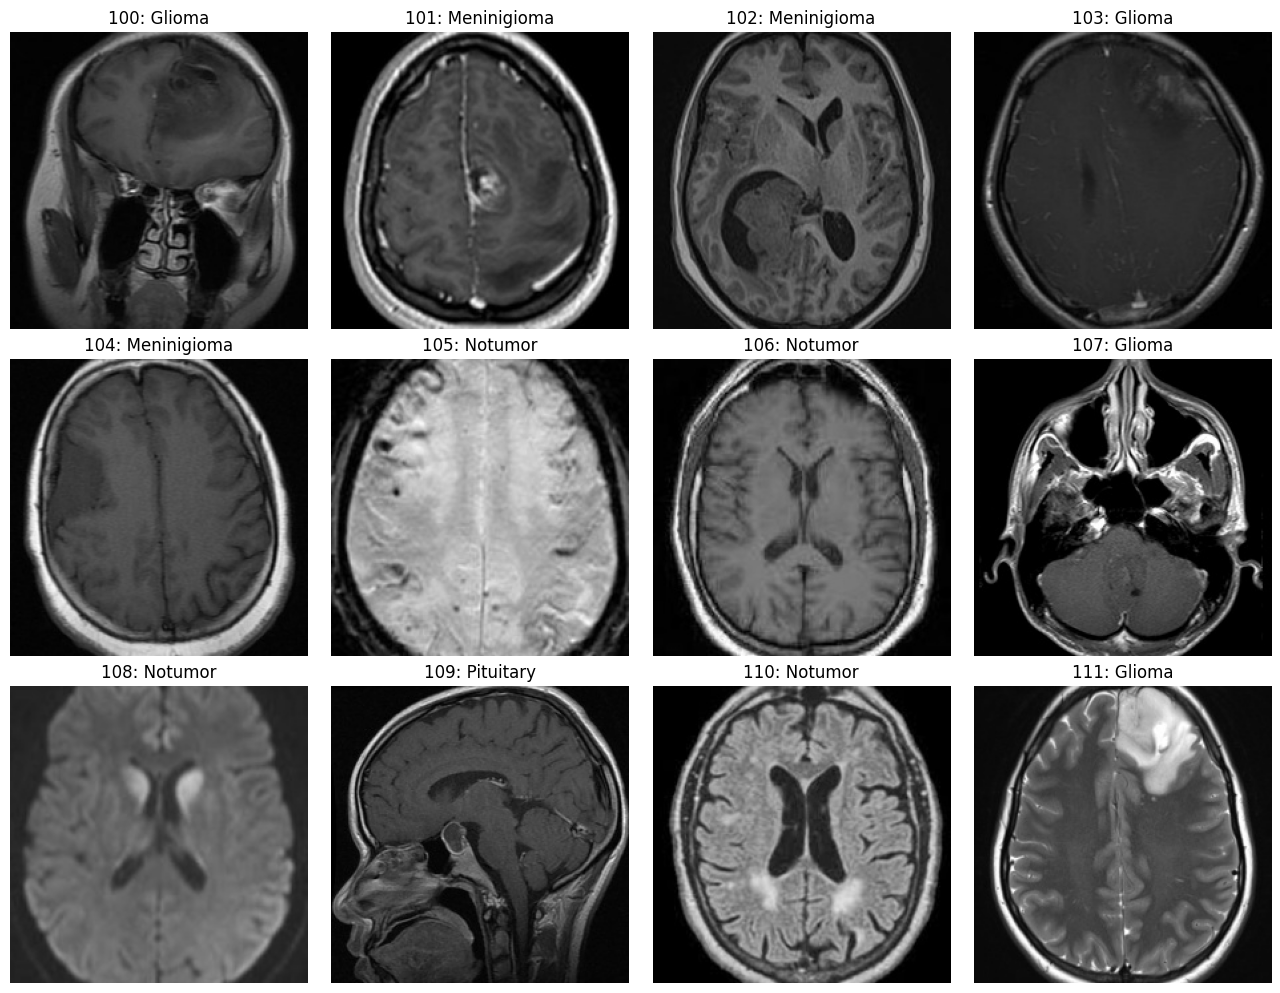

In [8]:
# Four different classes images from different angles
show_images(train_paths, train_index, class_mappings, im_size=224, figsize=(13,10),
            index_list=range(100, 112))

# **Data Augmentation & Preprocessing**

In [9]:
# Data Augmentation layers
data_augmentation = Sequential([
    RandomRotation(factor=0.1),
    RandomContrast(factor=0.1),
    RandomFlip(mode='horizontal')
])


# Training augmentation and normalization
def preprocess_train(image, label):
    # Apply augmentation
    image = data_augmentation(image)
    # Normalize
    image = image / 255.0
    return image, label


# For test dataset only applying normalization
def preprocess_test(image, label):
    image = image / 255.0
    return image, label

# Apply transformation to training and testing datasets
train_ds_preprocessed = train_ds.map(preprocess_train, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds.map(preprocess_test, num_parallel_calls=tf.data.AUTOTUNE)

def encode_labels(image, label): 
    return image, tf.one_hot(label, depth=num_classes)

train_ds_preprocessed = train_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)
test_ds_preprocessed = test_ds_preprocessed.map(encode_labels, num_parallel_calls=tf.data.AUTOTUNE)

# **Visualizing Augmentated Images**

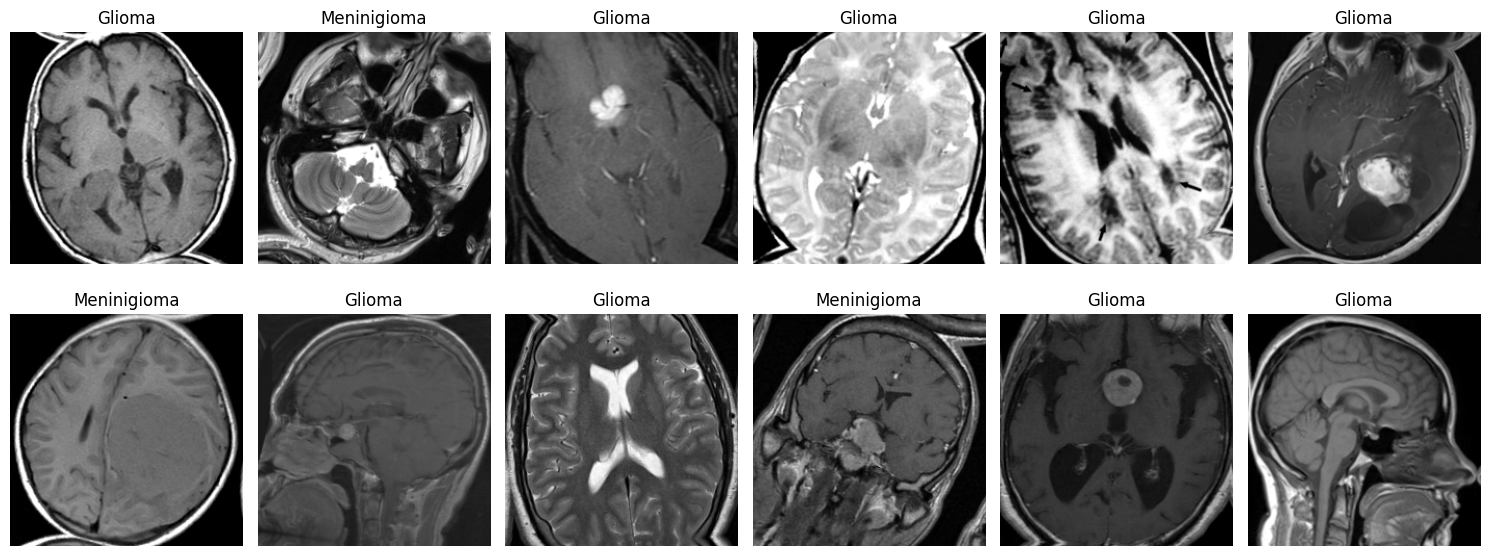

In [10]:
# Function to display augmented images
def plot_augmented_images(dataset, shape, class_mappings, figsize=(15, 6)):
    plt.figure(figsize=figsize)
    index_to_class = {v: k for k, v in class_mappings.items()}
    for images, label in dataset.take(1):
        labels = label.numpy().astype(int).flatten().tolist() 
        for i in range(shape[0]*shape[1]):
            ax = plt.subplot(shape[0], shape[1], i + 1)
            plt.imshow(images[i].numpy().squeeze(), cmap='gray')
            plt.title(index_to_class[labels[i]])
            plt.axis("off")
            
    plt.tight_layout()
    plt.show()

# Displaying augmented images
plot_augmented_images(train_ds_preprocessed, shape=(2, 6), class_mappings=class_mappings)


# **Model : Custom Convolutional Neural Network (CNN)** 

# 1. Building Model

In [11]:
# Building model
model_1 = Sequential([
    Input(shape=image_shape),
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(64, (5, 5), activation="relu"),
    MaxPooling2D(pool_size=(3, 3)),
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Conv2D(128, (4, 4), activation="relu"),
    MaxPooling2D(pool_size=(2, 2)),
    Flatten(),
    Dropout(0.5),
    Dense(512, activation="relu"),
    Dense(num_classes, activation="softmax")
])

# Model summary
model_1.summary()

# COompilng model with Adam optimizer
optimizer = Adam(learning_rate=0.0005, beta_1=0.9, beta_2=0.999)
model_1.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 220, 220, 64)   │         4,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 73, 73, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 69, 69, 64)     │       102,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 23, 23, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 128)    │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 7, 7, 128)      │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1152)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │         2,052 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,093,188 (4.17 MB)

 Trainable params: 1,093,188 (4.17 MB)

 Non-trainable params: 0 (0.00 B)

# 2. Model Training

In [12]:
# Callbacks for improved convergence of gradient, best test accuracy, and early stopping
model_rlr = ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=4, verbose=1)
model_mc = ModelCheckpoint('model_1_cnn.keras', monitor='val_accuracy', mode='max', save_best_only=True, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

# Training the model
history_1 = model_1.fit(
    train_ds_preprocessed,
    epochs=epochs,
    validation_data=test_ds_preprocessed,
    callbacks=[model_rlr, model_mc, early_stopping], 
    verbose=True
)

Epoch 1/80
  5/300 ━━━━━━━━━━━━━━━━━━━━ 9s 33ms/step - accuracy: 0.3730 - loss: 1.3828 

I0000 00:00:1716066004.075717     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 103ms/step - accuracy: 0.3635 - loss: 1.2890
Epoch 1: val_accuracy improved from -inf to 0.60417, saving model to model_1_cnn.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 43s 108ms/step - accuracy: 0.3638 - loss: 1.2886 - val_accuracy: 0.6042 - val_loss: 0.9124 - learning_rate: 5.0000e-04
Epoch 2/80
299/300 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.6202 - loss: 0.9046
Epoch 2: val_accuracy improved from 0.60417 to 0.72458, saving model to model_1_cnn.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 103ms/step - accuracy: 0.6204 - loss: 0.9041 - val_accuracy: 0.7246 - val_loss: 0.6889 - learning_rate: 5.0000e-04
Epoch 3/80
300/300 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.7103 - loss: 0.7107
Epoch 3: val_accuracy improved from 0.72458 to 0.77875, saving model to model_1_cnn.keras
300/300 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.7104 - loss: 0.7106 - val_accuracy: 0.7788 - val_loss: 0.5615 - learning_rate: 5.0000e-04
Epoch 4/80
299/300 ━━━━━━━━━━━━━━━━━

# 3. Model Evaluation

In [13]:
# Loading saved model
model_1 = load_model('model_1_cnn.keras')

# Evaluate model and test data accuracy
test_loss_1, test_acc_1 = model_1.evaluate(test_ds_preprocessed)
print(f"Test accuracy: {test_acc_1*100:0.2f}%")

75/75 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.9742 - loss: 0.0944
Test accuracy: 97.33%


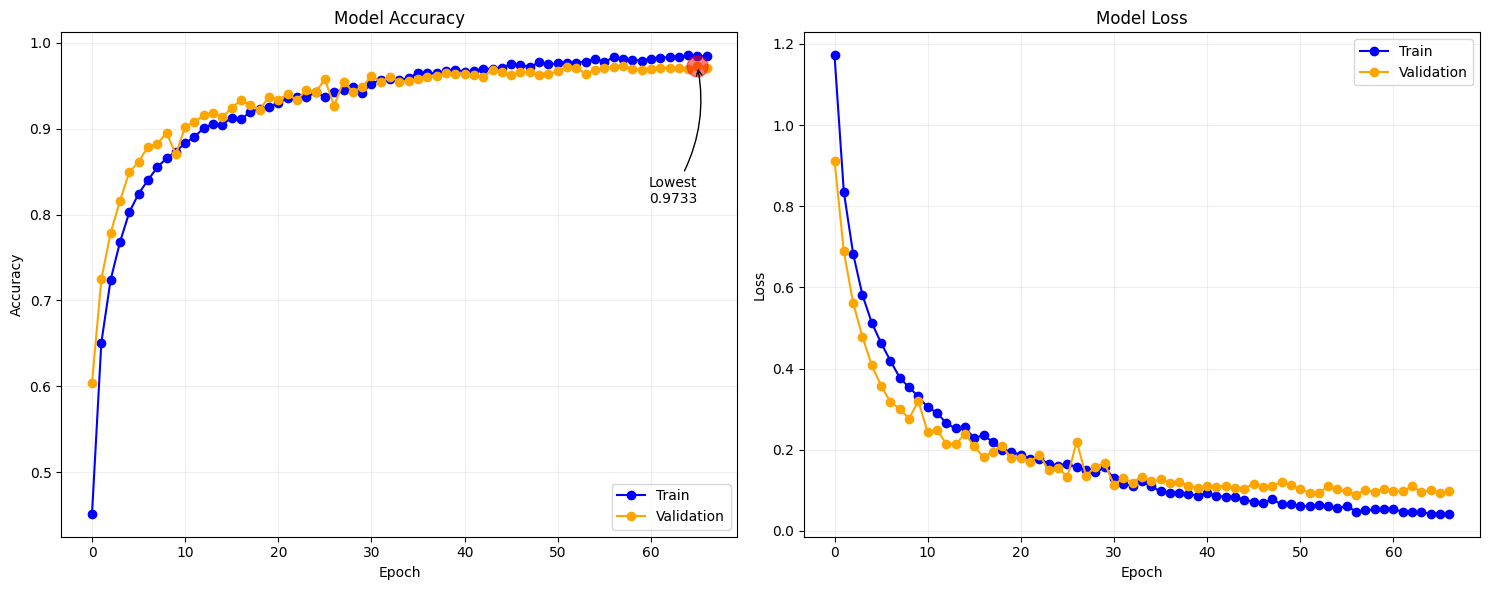

In [14]:
_, ax = plt.subplots(ncols=2, figsize=(15, 6))

# Plotting training and validation accuracy over epochs
ax[0].plot(history_1.history['accuracy'], marker='o', linestyle='-', color='blue')
ax[0].plot(history_1.history['val_accuracy'], marker='o', linestyle='-', color='orange')
ax[0].set_title('Model Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].legend(['Train', 'Validation'], loc='lower right')
ax[0].grid(alpha=0.2)

# Plotting training and validation loss over epochs
ax[1].plot(history_1.history['loss'], marker='o', linestyle='-', color='blue')
ax[1].plot(history_1.history['val_loss'], marker='o', linestyle='-', color='orange')
ax[1].set_title('Model Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].legend(['Train', 'Validation'], loc='upper right')
ax[1].grid(alpha=0.2)

# Highlight lowest validation accuracy
min_val_acc_epoch = np.argmax(history_1.history['val_accuracy'])
min_val_acc = np.max(history_1.history['val_accuracy'])
ax[0].plot(min_val_acc_epoch, min_val_acc, 'ro', markersize=15, alpha=0.5)
ax[0].annotate(f'Lowest\n{min_val_acc:.4f}', xy=(min_val_acc_epoch, min_val_acc), 
               xytext=(min_val_acc_epoch - 100, min_val_acc - 100), textcoords='offset points',
               arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=.2'))

plt.tight_layout()
plt.show()

# 4. Confusion matrix

In [15]:
# Using test data for true and preductions
true_labels_1 = []
predicted_labels_1 = []

# Iterate over dataset to collect predictions and true labels
# Unbatch to get sample-wise prediction
for images, labels in test_ds_preprocessed.unbatch():  
    # Store true labels (Convert one-hot to index)
    true_label = np.argmax(labels.numpy()) 
    true_labels_1.append(true_label)
    
    # Get model prediction (Predict expects batch dimension)
    pred = model_1.predict(tf.expand_dims(images, 0), verbose=False)  
    predicted_label = np.argmax(pred)
    predicted_labels_1.append(predicted_label)

In [16]:
def plot_confusion_matrix(true_labels_1, predicted_labels_1, class_mappings, metrics=False, cmap='Blues'):
    # Compute  confusion matrix
    cm = confusion_matrix(true_labels_1, predicted_labels_1)
    plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=cmap, cbar=False)
    plt.title("Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")

    # Mapping of indices to class names in class_mappings
    plt.xticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), ha='center')
    plt.yticks(ticks=np.arange(num_classes) + 0.5, labels=class_mappings.keys(), va='center')
    plt.show()

    if metrics:
        # Precision, Recall, and F1-Score for each class & Overall accuracy
        precision = np.diag(cm) / np.sum(cm, axis=0)
        recall = np.diag(cm) / np.sum(cm, axis=1)
        f1_scores = 2 * precision * recall / (precision + recall)
        accuracy = np.sum(np.diag(cm)) / np.sum(cm)

        print("Class-wise metrics:")
        for i in range(len(class_mappings)):
            class_name = list(class_mappings.keys())[i]
            print(f"\033[94mClass: {class_name}\033[0m")
            print(f"Precision: {precision[i]:.4f}")
            print(f"Recall: {recall[i]:.4f}")
            print(f"F1-Score: {f1_scores[i]:.4f}\n")

        print(f"\033[92mOverall Accuracy: {accuracy:.4f}\033[0m")

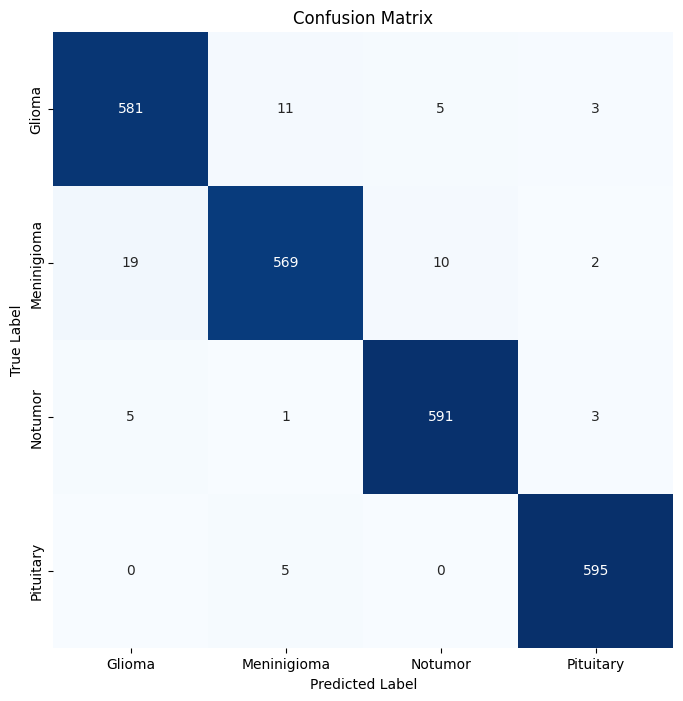

Class-wise metrics:
Class: Glioma
Precision: 0.9603
Recall: 0.9683
F1-Score: 0.9643

Class: Meninigioma
Precision: 0.9710
Recall: 0.9483
F1-Score: 0.9595

Class: Notumor
Precision: 0.9752
Recall: 0.9850
F1-Score: 0.9801

Class: Pituitary
Precision: 0.9867
Recall: 0.9917
F1-Score: 0.9892

Overall Accuracy: 0.9733


In [17]:
# Confusion matrix and netrics from predictions
plot_confusion_matrix(true_labels_1,
                      predicted_labels_1, 
                      class_mappings,
                      metrics=True)

In [20]:
from sklearn.metrics import classification_report

report = classification_report(true_labels_1, predicted_labels_1)
print(report)


              precision    recall  f1-score   support

           0       0.96      0.97      0.96       600
           1       0.97      0.95      0.96       600
           2       0.98      0.98      0.98       600
           3       0.99      0.99      0.99       600

    accuracy                           0.97      2400
   macro avg       0.97      0.97      0.97      2400
weighted avg       0.97      0.97      0.97      2400

